<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/center-for-computational-psychiatry/course_spice/blob/master/modules/module-08_linear-models.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Linear Modeling
This tutorial was inspired by and adapted from Shawn A. Rhoads' [PSYC 347 Course](https://shawnrhoads.github.io/gu-psyc-347/) [[CC BY-SA 4.0 License](https://creativecommons.org/licenses/by-sa/4.0/)] and [Neuromatch Academy tutorials](https://github.com/NeuromatchAcademy/course-content) [[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)].
## Learning objectives

This notebook is intended to teach you basic python syntax to fit a linear regression to data.

## What is a linear model?

In its most basic form, a linear model can be written like this (e.g., a simple linear regression):

$$
y_n = intercept + b \times x_n + \epsilon_n
$$

where $y$ is the **dependent (outcome) variable** and $x$ is an **independent (explanatory/manipulated) variable**---these variables represent data (each participant $n$ has an observation at $x$, $y$). 

$y$ is a function of $x$ and is determined by 2 components:
- a non-random component: $intercept + \beta \times x_n$
- random component: $\epsilon_n$

The $intercept$ is the value of $y$ when $x=0$. $\beta$ is a weighted parameter that determines the slope of the fitted linear model. We will determine the values of these parameters by fitting a linear model.

The $error$ ($\epsilon_n$) describes the random component of the linear relationship between $x$ and $y$---this is the difference between the true values ($y$) and the predicted values ($\hat{y}$). We can solve this equation for the error:

$$
y_n = (intercept + \beta \times x_n) + \epsilon_n
$$
$$
y_n = \hat{y_n} + \epsilon_n
$$
$$
\epsilon_n = y_n - \hat{y_n}
$$



In [227]:
# let's begin by importing packages
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize

%matplotlib inline

In [17]:
our_data = pd.read_csv('https://raw.githubusercontent.com/Center-for-Computational-Psychiatry/course_spice/main/modules/resources/data/Banker_et_al_2022_QuestionnaireData_clean.csv')


## Model Simulations
Simulations are great ways to test models. By creating a simple synthetic dataset, we will know the true underlying model which allows us to see how our estimation efforts compare in uncovering the real model.

Below, we will simulate a linear relationship between two variables `x` (Depression) and `y` (Anxiety), and then we will add some "noise" to those data. Let's create these data based on the means and standard deviations of our variables in the dataset.

In [112]:
# setting a fixed seed to our random number generator 
# ensures we will always
# get the same psuedorandom number sequence
np.random.seed(42)

# Let's set some parameters
beta_coeff = .237
n_subjects = len(our_data)

# Draw x
intercept = 9.66
x0 = np.ones((n_subjects, 1))

# generate a random sample from a truncated normal distribution based on the mean, standard deviation, range, and number of subjects
x1 = np.random.normal(our_data['Depression'].mean(),
                      our_data['Depression'].std(),
                      (n_subjects,1))
X = np.hstack((x0, x1))

# sample from a standard normal distribution
noise = np.random.normal(1, 2, (n_subjects,1)) 

# calculate y
y = (intercept + beta_coeff * x1) + noise

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


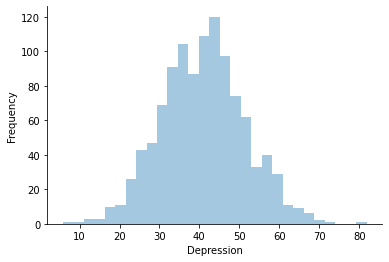

In [113]:
# Plot a histogram
ax = sns.distplot(x1, kde=False)
ax.set_xlabel('Depression')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()

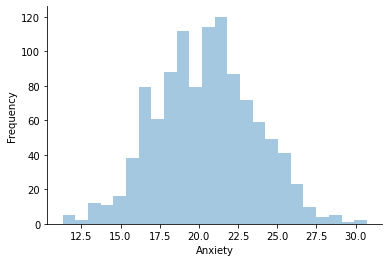

In [114]:
# Plot a histogram
ax = sns.distplot(y, kde=False)
ax.set_xlabel('Anxiety')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()

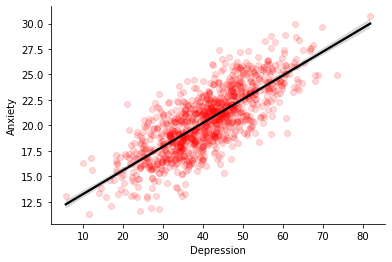

In [115]:
# Plot the results
ax = sns.regplot(x=x1, y=y,
                 scatter_kws={'alpha':0.15, 'color':'red'}, 
                 color='black')
ax.set_xlabel('Depression')
ax.set_ylabel('Anxiety')
sns.despine()
plt.show()


Now that we have our noisy dataset, we can try to estimate the underlying model that produced it. We use MSE to evaluate how successful a particular slope estimate $\hat{\beta}$ is for explaining the data, with the closer to 0 the MSE is, the better our estimate fits the data.

<hr>

## Model Fitting

Now, we will fit our simulated data to a simple linear regression, using least-squares optimization. 

**Ordinary least squares** is a very common optimization procedure that we are going to use for data fitting. 

Let's recall our simple linear model above. Suppose we have a set of measurements, $y_{n}$ (the "dependent" variable) obtained for different input values, $x_{n}$ (the "independent" or "explanatory" variable). Suppose we believe the measurements are proportional to the input values, but are corrupted by some (random) measurement errors, $\epsilon_{n}$, that is:

$$\hat{y_{n}}= \beta_0 + \beta_1 x_{n}+\epsilon_{n}$$

for some unknown parameters ($\beta_0$, $\beta_1$). The least squares regression problem uses **mean squared error (MSE)** as its objective function, it aims to find the values of $\beta_0$ and $\beta_1$ by minimizing the average of squared errors:

$$
\min _{\beta} \frac{1}{N}\sum_{n=1}^{N}\left(y_{n}-\hat{y_{n}}\right)^{2}
$$

We will now explore how MSE is used in fitting a linear regression model to data. 

### Computing MSE

In this exercise we will implement a method to compute the mean squared error (MSE) for a set of inputs $x$, measurements $y$, and slope estimates $\hat{\beta_0}$ and $\hat{\beta_1}$. We will then compute and print the MSE for 3 different estimates of $\hat{\beta_1}$.

In [116]:
def mse(beta_hats, X, y):
    """Compute the mean squared error

    Args:
    beta_hats (list of floats): A list containing the estimate of the intercept parameter and the estimate of the slope parameter
    X (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding measurement values to the inputs.

    Returns:
    y_hat (float): The estimated y_hat computed from X and the estimated parameter(s).
    mse (float): The mean squared error of the model with the estimated parameter(s).
    """
    
    assert len(beta_hats) == np.shape(X)[1]
    
    # Compute the estimated y
    y_hat = 0
    for index, b in enumerate(beta_hats):
        y_hat += b*X[:,index]
    
    y_hat = y_hat.reshape(len(y_hat),1)
    
    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return y_hat, mse

In [119]:
intercept = 9.5
possible_betas = [.2,.25,.3,.35]

for beta_hat in possible_betas:
        
    y_hat, MSE_val = mse([intercept, beta_hat], X, y)
    print(f"beta_hat of {beta_hat:.3f} has an MSE of {MSE_val:.2f}")

beta_hat of 0.200 has an MSE of 11.66
beta_hat of 0.250 has an MSE of 4.49
beta_hat of 0.300 has an MSE of 6.23
beta_hat of 0.350 has an MSE of 16.88


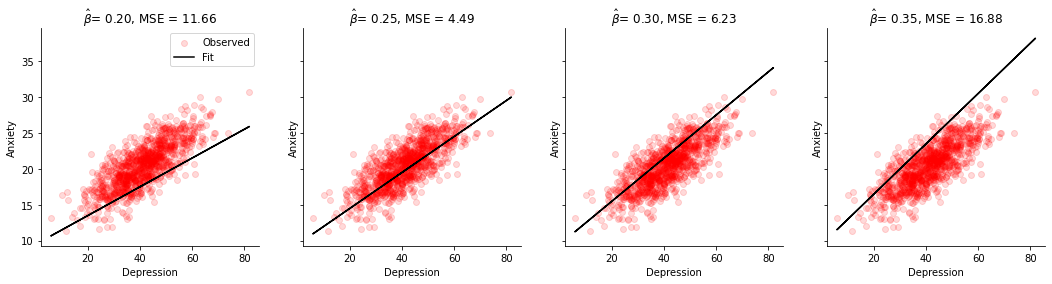

In [124]:
fig, axes = plt.subplots(ncols=4, figsize=(18, 4), sharey=True)

for beta_hat, ax in zip(possible_betas, axes):

    # True data
    ax.scatter(x1, y, label='Observed', alpha=.15, color='red')  # our data scatter plot

    # Compute and plot predictions
    y_hat, MSE_val = mse([intercept, beta_hat], X, y)

    ax.plot(x1, y_hat, color='black', label='Fit')  # our estimated model

    ax.set(
        title= fr'$\hat{{\beta}}$= {beta_hat:.2f}, MSE = {MSE_val:.2f}',
        xlabel='Depression',
        ylabel='Anxiety')
    
    sns.despine()
    
axes[0].legend()
plt.show()

<hr>

### Model parameters
Using an interactive widget, we can easily see how changing intercept and slope estimates change a model fit. We display the **residuals** (differences between observed and predicted data) as line segments between the actual data and the corresponding predicted data on the model fit line.

In [129]:
# interactive display (if not using Jupyter Book)
%config InlineBackend.figure_format = 'retina'
@widgets.interact(beta_hat=widgets.FloatSlider(.25, min=.05, max=.5),
                  intercept=widgets.FloatSlider(9.5, min=5, max=20))
def plot_data_estimate(intercept, beta_hat):
    # compute error
    y_hat = (intercept*X[:,0] + beta_hat*X[:,1]).reshape(len(y),1)
    MSE_val = np.mean((y - y_hat)**2)
    
    # plot
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y, label='Observed', alpha=.15, color='red')  # our data scatter plot
    ax.plot(X[:,1], y_hat, color='black', label='Fit')  # our estimated model

    # plot residuals
    ymin = np.minimum(y, y_hat)
    ymax = np.maximum(y, y_hat)
    ax.vlines(X[:,1], ymin, ymax, alpha=0.15, label='Residuals', color='red')

    ax.set(
        title=fr"$intercept={intercept:0.2f}, \hat{{\beta}}$ = {beta_hat:0.2f}, MSE = {MSE_val:.2f}",
        xlabel='x',
        ylabel='y')
    
    ax.legend()
    plt.show()

interactive(children=(FloatSlider(value=9.5, description='intercept', max=20.0, min=5.0), FloatSlider(value=0.…

<hr>

### Least-squares minimization

While the approach detailed above (computing MSE at various values of $\hat\beta$) quickly got us to a good estimate, it still relied on us guessing which beta values to select. If we didn't pick good guesses to begin with, we might miss the best possible parameter values.

Thus, there must be a better way "guess-timate" them, right?

Why don't we try an **exhaustive search** of across a specified range of parameter values?

In [170]:
# Exhaustive search 
param_b0 = np.linspace(7, 18, 20)
param_b1 = np.linspace(.1, .6, 50)

first_run = 'first'
mse_out = []
for b0 in param_b0:
    for b1 in param_b1:
        if first_run is not None:
            first_run = None
            Params = [b0, b1]
        else:
            Params = np.vstack((Params, [b0, b1]))
        mse_out = np.append(mse_out, mse([b0, b1], X, y)[1])

In [188]:
# From out exhaustive search:
# let's see if we can recover the index with the smallest MSE
min_index = np.argmin(mse_out)

print(f'b0, b1 = {Params[min_index]}, MSE = {mse_out[min_index]:.2f}')

b0, b1 = [10.47368421  0.24285714], MSE = 3.97


We see that our fit is $b_0 = 10.47$ and $b_1 = .24$, which is quite close to our original!

**We can also plot our search onto a heatmap!**

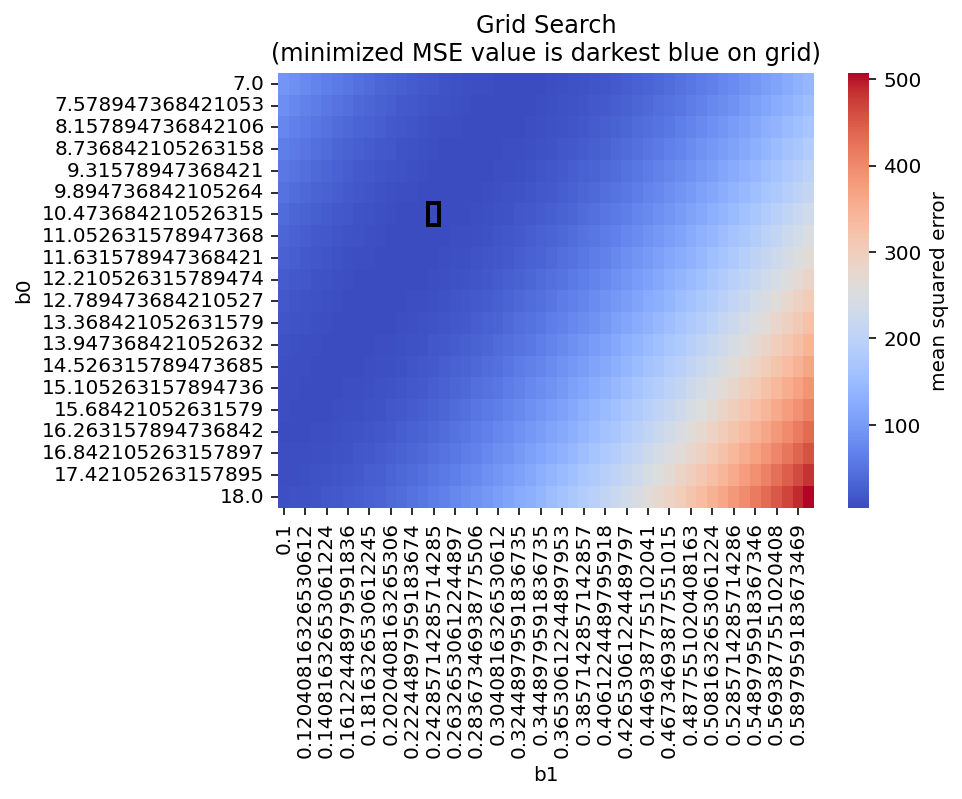

In [215]:
grid_search_data = pd.DataFrame({'b0': Params[:,0],
                                 'b1': Params[:,1], 
                                 'MSE': mse_out})
data_pivoted = grid_search_data.pivot("b0", "b1", "MSE")

ax = sns.heatmap(data_pivoted,
            cmap='coolwarm',
            cbar_kws={'label': 'mean squared error'})
            
# find the indices of the minimum value in the heatmap
min_row, min_col = np.unravel_index(data_pivoted.values.argmin(), data_pivoted.shape)

# create the rectangle
rect = Rectangle((min_col, min_row), 1, 1, fill=False, edgecolor='black', linewidth=2)
ax.add_patch(rect)

plt.title("Grid Search\n(minimized MSE value is darkest blue on grid)")
plt.show()

<hr>

### scipy.optimize.minimize

But, writing an exhaustive search by hand is prone to errors, too! It depends largely on the specified parameters for the search (e.g., we only sampled 7 to 18 in 20 increments above for $b_0$).

It can also be very time-consuming and computationally-expensive.

Instead, we can utilize minimization algorithms that we optimized to solve minimization problems like this. Let's use the `scipy.optimize.minimize` function, which takes in the following inputs:
- a cost function to minimize (`mse()` in our case)
- starting points for the parameters to estimate (starting points for `b0` and `b1` in our case)
- other arguments that need to be input into our objective function (`X` and `y` in our case)

It will return an `OptimizeResult` object containing the estimated parameters (along with the value of minimized MSE)

In [216]:
def mse_to_minimize(beta_hats, X, y):
    """Compute the mean squared error

    Args:
    beta_hats (list of floats): A list containing the estimate of the intercept parameter and the estimate of the slope parameter
    X (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding measurement values to the inputs.
    
    Returns:
    mse (float): The mean squared error of the model with the estimated parameter(s).
    """
    
    assert len(beta_hats) == np.shape(X)[1]
    
    # Compute the estimated y
    y_hat = 0
    for index, b in enumerate(beta_hats):
        y_hat += b*X[:,index]
    
    y_hat = y_hat.reshape(len(y_hat),1)
    
    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return mse

In [221]:
def plot_observed_vs_predicted(beta_hats, X, y):
    """ Plot observed vs predicted data

    Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    beta_hats (ndarray): An array of shape (betas,) that contains the estimate of the slope parameter(s)

    """
    y_hat, MSE_val = mse(beta_hats, X, y)
    
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y, label='Observed', alpha=.15, color='red')  # our data scatter plot
    ax.plot(X[:,1], y_hat, color='black', label='Fit')  # our estimated model

    # plot residuals
    ymin = np.minimum(y, y_hat)
    ymax = np.maximum(y, y_hat)
    ax.vlines(X[:,1], ymin, ymax, 'red', alpha=0.15, label='Residuals')

    ax.set(
        title=fr"$intercept={beta_hats[0]:0.2f}, \hat{{\beta}}$ = {beta_hats[1]:0.2f}, MSE = {MSE_val:.2f}",
        xlabel='x',
        ylabel='y')
    
    ax.legend()
    plt.show()

b0, b1 = [10.90358817  0.23304076], MSE = 3.957338734657976


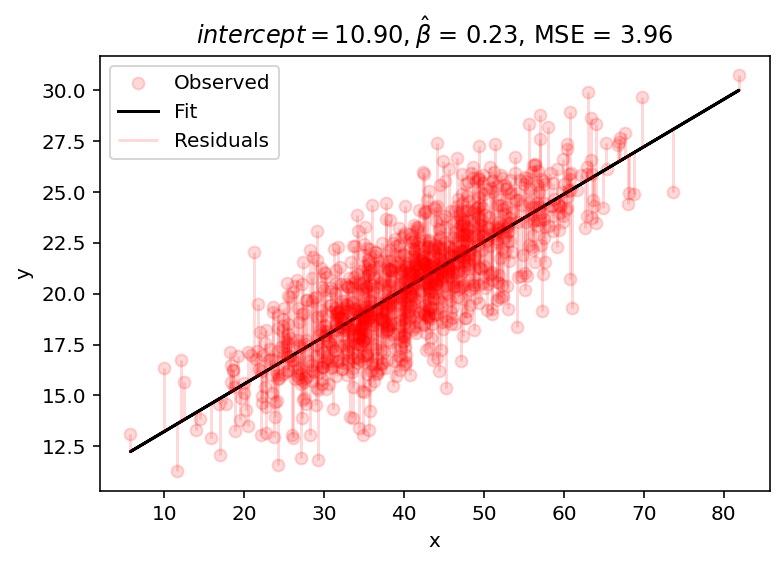

In [222]:
# minimize MSE using scipy.optimize.minimize
res = minimize(mse_to_minimize, # objective function
               (350, -1.75), # estimated starting points
               args=(X, y)) # arguments

print(f'b0, b1 = {(res.x)}, MSE = {res.fun}')
plot_observed_vs_predicted([res.x[0], res.x[1]], X, y)

We see that we can get a better fit: $b_0 = 10.90$ and $b_1 = 0.23$, which fairly accurate! Note that our **MSE** value is also smaller than last time!

### Actual data versus fitted data

In addition to reviewing the residuals, we can also look at the actual simulated data (`y` or $y$) versus fitted data (`y_hat` or $\hat{y}$). In other words, we can visualize the how the fitted values ($\hat{y}$) compare to the actual data ($y$) to assess how well our model recovered our original parameters. We can also correlate $y$ with $\hat{y}$ (a good model fit will show a strong correlation). This is helpful because we are often dealing with more than one dimension.

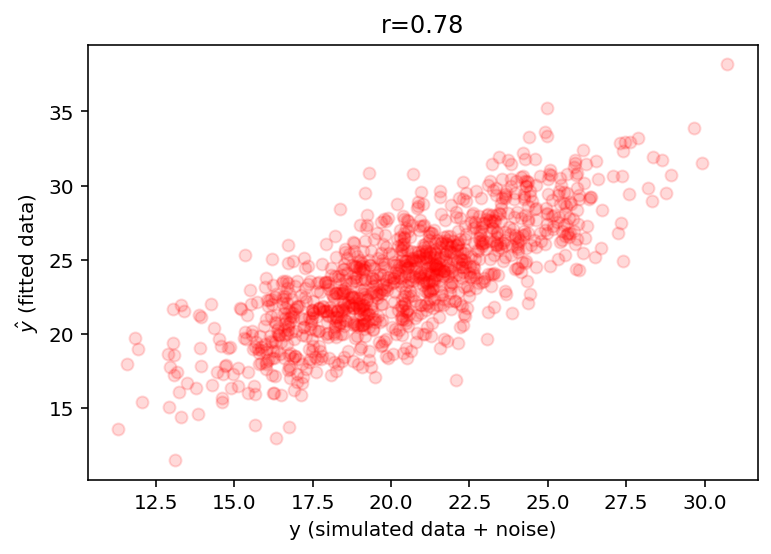

In [225]:
# compute y_hat, which is the prediction of y given the slope and intercept
y_hat = (intercept*X[:,0] + beta_hat*X[:,1]).reshape(len(y),1)

# correlate y and y_hat
corrcoef = np.corrcoef(y.flatten(),y_hat.flatten())[0,1]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(y, y_hat, color='red', alpha=.15)  # produces a scatter plot
ax.set(xlabel='y (simulated data + noise)', ylabel=fr'$\haty$ (fitted data)')
plt.title((f'r={corrcoef:.2f}'))
sns.despine()
plt.show()

Awesome! Looks pretty nice!

### Comparison to a statistics package
Okay, cool!

Let's see how our manual linear model fitting compares to a typical statistical packages. Let's import `scipy.stats` and run a simple linear regression with our observed data!

In [226]:
stat_res = stats.linregress(X[:,1],y[:,0])

y_hat_new = (stat_res.intercept + stat_res.slope*X[:,1]).reshape((len(y),1))

print(f'b1 = {stat_res.slope:.2f} , b0 = {stat_res.intercept:.2f}, MSE = {np.mean((y - y_hat_new)**2):.2f}')

b1 = 0.23 , b0 = 10.90, MSE = 3.96


## Bonus: Machine Learning

The basis of all machine learning is training mathematical models like these to make predictions about new data. In this ***VERY SIMPLE** case, we are training a linear model to predict the value of $y$ given a value of $x$, but we did not apply the model to unseen (testing) data. This could look like applying the model to a new set of data to predict the value of $y$ given a value of $x$. What do you think this might look like in a real-world scenario?

Let's try a brief, simple example using our actual data:

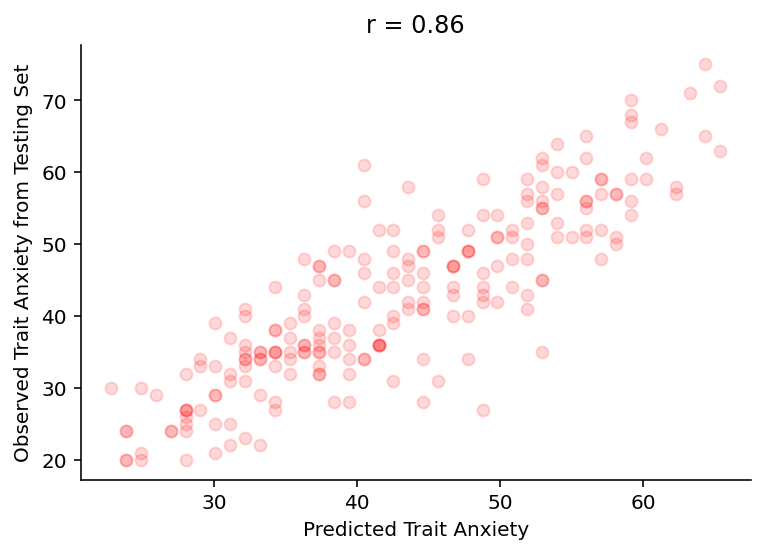

In [240]:
# first we will split data into training and testing sets
# 80% of our data will be used for training, 20% for testing
training_data = our_data.sample(frac=0.8, random_state=42)
testing_data = our_data.drop(training_data.index)

# fit a linear model to the training data using linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(training_data['Depression'], training_data['Trait Anxiety'])

# predict values for the testing data using the fitted model
predicted_values = intercept + slope * testing_data['Depression']

# compute correlation coefficient between predicted and actual values
corrcoef = np.corrcoef(testing_data['Trait Anxiety'], predicted_values)[0,1]

# plot the actual data versus the predicted data
plt.scatter(predicted_values, testing_data['Trait Anxiety'], color='red', alpha=.15)
# plt.scatter(testing_data['Depression'], , label='predicted', color='blue', alpha=.15)
plt.xlabel('Predicted Trait Anxiety')
plt.ylabel('Observed Trait Anxiety from Testing Set')
# plt.legend()
plt.title(f'r = {corrcoef:.2f}')
sns.despine()
plt.show()


This is the basis of machine learning! Our linear model (which we "trained" on 80% of our original data) does fairly well at predicting the value of $y$ given a value of $x$ in the left-out 20% of the data (our "testing" data), but it's not perfect. Linear models are some of the simplest models and thus are not very reliable in real-world scenarios. However, they are a good starting point for understanding how machine learning works. Typically, we will need way more data and more complex models to predict outcomes in the real-world.

I encourage you to explore this topic further and reach out if you have any questions!